# 05. Model Experiment: LSTM (Deep Learning)
**Project:** Climate-Sensitive Health Forecasting (Dengue - Davao Pilot)\
**Author:** Edsequille Publico

### **Goal**
Use TensorFlow/Keras to model temporal dependencies.

✅ Random Seeds Locked. Results will now be reproducible.
LSTM Input Shape: (560, 1, 26)
Training with Smart Checkpoints...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1451
Epoch 1: val_loss improved from inf to 0.05373, saving model to /kaggle/working/dengue_lstm_best.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1438 - val_loss: 0.0537
Epoch 2/100
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1107
Epoch 2: val_loss did not improve from 0.05373
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1140 - val_loss: 0.0584
Epoch 3/100
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0996
Epoch 3: val_loss improved from 0.05373 to 0.05040, saving model to /kaggle/working/dengue_lstm_best.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1016 - val_loss: 0.0504
Epoch 4/100
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0935
Epoch 4: val_loss improved from 0.05040 to 0.04871, saving model to /kaggle/working/dengue_lstm_best.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0960 - val_loss: 0.0487
Epoch 5/100
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0914
Epoch 5: val_loss did not

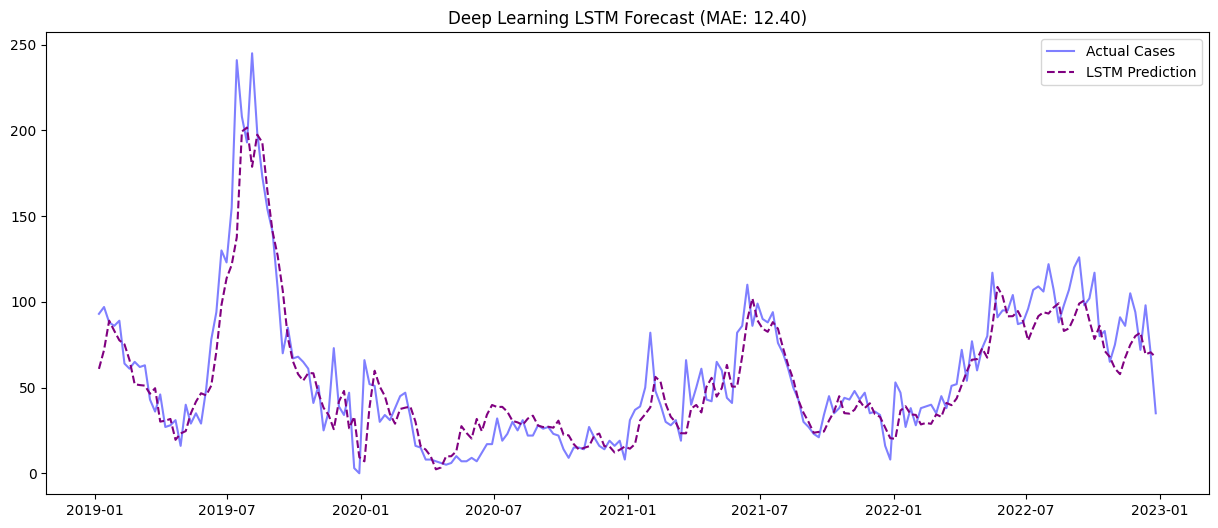

✅ Plot saved to: /kaggle/working/forecast_lstm.png


<Figure size 640x480 with 0 Axes>

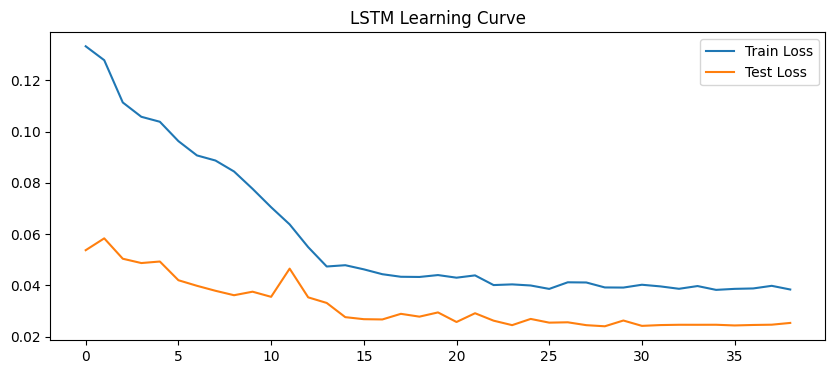

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import random

# Reproducibility
# --- SET RANDOM SEED (Lock the randomness) ---
# 1. Set Python seed
random.seed(42)

# 2. Set NumPy seed
np.random.seed(42)

# 3. Set TensorFlow seed
tf.random.set_seed(42)

print("✅ Random Seeds Locked. Results will now be reproducible.")
# Load Data
PROCESSED_DIR = '/kaggle/input/dengue-defensor-features'
df = pd.read_csv(os.path.join(PROCESSED_DIR, '02_features.csv'), index_col='date', parse_dates=True)

# --- 1. PREPROCESSING FOR DEEP LEARNING ---
# LSTMs are sensitive to scale. We must scale data to [0, 1].

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Define Split
SPLIT_DATE = '2019-01-01'
train = df[df.index < SPLIT_DATE]
test = df[df.index >= SPLIT_DATE]

# Fit Scaler ONLY on Training data (prevent data leakage)
X_train_scaled = scaler_X.fit_transform(train.drop(columns=['cases']))
y_train_scaled = scaler_y.fit_transform(train[['cases']])

X_test_scaled = scaler_X.transform(test.drop(columns=['cases']))
y_test_scaled = scaler_y.transform(test[['cases']])

# --- 2. RESHAPE FOR LSTM (Samples, Timesteps, Features) ---
# XGBoost takes 2D data (Rows, Columns).
# LSTM takes 3D data (Rows, TimeSteps, Columns).
# Since our features are ALREADY lagged, we can treat Timesteps=1 for this simple architecture.

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"LSTM Input Shape: {X_train_lstm.shape}")

# --- 3. BUILD LSTM ARCHITECTURE ---
model = Sequential()

# Layer 1: LSTM
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.2)) # Prevent overfitting

# Layer 2: Dense (Output)
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

# --- IMPROVED TRAINING WITH CHECKPOINT ---
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Define where to save the BEST version
model_path = '/kaggle/working/dengue_lstm_best.keras' # .keras is better for TensorFlow

# 2. Setup Callbacks
# Checkpoint: Save ONLY if validation MAE improves
checkpoint = ModelCheckpoint(
    model_path, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

# Early Stopping: Stop if it doesn't get better for 10 epochs (saves time)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# 3. Train
print("Training with Smart Checkpoints...")
history = model.fit(
    X_train_lstm, y_train_scaled,
    epochs=100, # Give it more time, it will stop early anyway
    batch_size=16,
    validation_data=(X_test_lstm, y_test_scaled),
    callbacks=[checkpoint, early_stop], # Add the callbacks here
    verbose=1,
    shuffle=False
)

print(f"✅ Best Model saved to: {model_path}")

# --- 5. EVALUATE ---
# Predict (Output is scaled 0-1)
y_pred_scaled = model.predict(X_test_lstm)

# Inverse Scale (Convert 0-1 back to "Number of Cases")
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Metric
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"\n✅ LSTM MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test_actual, label='Actual Cases', color='blue', alpha=0.5)
plt.plot(test.index, y_pred, label='LSTM Prediction', color='purple', linestyle='--')
plt.title(f'Deep Learning LSTM Forecast (MAE: {mae:.2f})')
plt.legend()
plt.show()

output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True) # Creates folder if it doesn't exist

save_path = os.path.join(output_dir, 'forecast_lstm.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight') # dpi=300 makes it high quality

print(f"✅ Plot saved to: {save_path}")

# Plot Loss Curve (Did it learn?)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM Learning Curve')
plt.legend()
plt.show()